# Retraining Inception V3

In this notebook, I will go over steps to retrain Inception V3 for the skin cancer dataset.

In [1]:
import os
from glob import glob

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding

from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler
from keras.regularizers import l2
import tensorflow as tf


%matplotlib inline
import matplotlib.pyplot as plt

## Load in the Dataset

In [2]:
X_train = np.load("256_192_train.npy")

In [3]:
y_train = np.load("train_labels.npy")

In [4]:
X_val = np.load("256_192_val.npy")

In [5]:
y_val = np.load("val_labels.npy")

In [6]:
X_train.shape, X_val.shape

((37989, 256, 192, 3), (902, 192, 256, 3))

In [7]:
y_train.shape, y_val.shape

((37989,), (902,))

In [8]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

In [9]:
y_train.shape, y_val.shape

((37989, 7), (902, 7))

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.callbacks import Callback

# Custom callback for F1 score
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
    
    def on_epoch_end(self, epoch, logs={}):
        val_predict = (np.asarray(self.model.predict(X_val))).round()
        val_targ = y_val
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        print(f"— val_f1: {_val_f1} — val_precision: {_val_precision} — val_recall: {_val_recall}")
        return

metrics = Metrics()

## Load in Pretrained Inception Model

In [11]:
pre_trained_model = InceptionV3(input_shape=(192, 256, 3), include_top=False, weights="imagenet")

In [12]:
for layer in pre_trained_model.layers:
    print(layer.name)
    if "BatchNormalization" in layer.__class__.__name__:
        layer.trainable = True
    
print(len(pre_trained_model.layers))

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed0
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
average_pooling2d_1
conv2d_12
conv2d_14
conv2d_17
conv2d_18
batch_normalization_12
batch_normalization_14
batch_normalization_17
batch_normalization_18
activation_12
activation_14
activation_17
activation_18
mixed1
conv2d_22
batch_normalization_22
activation_22
conv2d

In [13]:
last_layer = pre_trained_model.get_layer('mixed10')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

last layer output shape: (None, 4, 6, 2048)


## Define the Model

In [14]:
# Flattening the output layer to 1 dimension
x = layers.GlobalMaxPooling2D()(last_output)
# Adding a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Adding a dropout rate of 0.5
x = layers.Dropout(0.5)(x)
# Adding a final softmax layer for classification
x = layers.Dense(7, activation='softmax')(x)
# Configure and compile the model
model = Model(pre_trained_model.input, x)
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

c:\Users\chara_eoccfea\anaconda3\envs\py310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 127, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 127, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

## Training

We will retrain the entire model rather than just performing transfer learning. This approach is chosen due to a known issue with the batch normalization layers in Keras. Regardless of whether these layers are frozen during training, they will utilize statistics from the mini-batch. However, during inference, the model uses the statistics learned from the original dataset. Consequently, if only the top layers of the model are fine-tuned, they will adapt to the new dataset's statistics, but during inference, they will process data scaled by the original dataset's statistics. This discrepancy can lead to poor validation accuracy when using transfer learning with InceptionV3. To address this, we will retrain the entire model using a very low learning rate of 0.0001 and a high momentum value. Additionally, we'll employ a learning rate reduction strategy that halves the learning rate if there's no improvement in validation accuracy for three consecutive epochs. The model will be trained for a limited number of epochs, specifically 20, to prevent significant deviations from the pretrained weights and avoid overfitting to the training data.

### Feature Extraction
Prior to retraining our model, it is advisable to freeze the layers of InceptionV3 and focus on training only the newly added fully-connected and classification layers. This precaution ensures that the weights of these top layers are not initialized arbitrarily. The underlying rationale is that without first establishing feature extraction, the gradients could be excessively large, leading to an undesirable and substantial alteration of the weights that were already learned in the pretrained model.








In [ ]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.2, 
                                            min_lr=0.000001, cooldown=2)

In [16]:
train_datagen = ImageDataGenerator(rotation_range=60, width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, fill_mode='nearest', brightness_range=[0.8,1.2], rescale=1./255, horizontal_flip=True, vertical_flip=True)

train_datagen.fit(X_train)

val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [17]:
batch_size = 64
epochs = 3
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
history = model.fit_generator(train_datagen.flow(X_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = val_datagen.flow(X_val, y_val),
                              verbose = 1, steps_per_epoch=(X_train.shape[0] // batch_size), 
                              validation_steps=(X_val.shape[0] // batch_size), callbacks=[lr_scheduler])

Epoch 1/3
593/593 [==============================] - 298s 483ms/step - loss: 1.5611 - accuracy: 0.6069 - val_loss: 0.9889 - val_accuracy: 0.6741
Epoch 2/3
593/593 [==============================] - 267s 450ms/step - loss: 1.0282 - accuracy: 0.6688 - val_loss: 0.9919 - val_accuracy: 0.6451
Epoch 3/3
593/593 [==============================] - 249s 420ms/step - loss: 0.9710 - accuracy: 0.6719 - val_loss: 0.8978 - val_accuracy: 0.6920


In [ ]:
# Unfreeze the top layers of the model
pre_trained_model.trainable = True
fine_tune_at = 280

for layer in pre_trained_model.layers[:fine_tune_at]:
    layer.trainable = False

### Retraining
At this stage, we are engaging in a full retraining of the model. The objective is to fine-tune the existing weights slightly to better fit our specific dataset, while ensuring we do not significantly alter the weights that have been pre-established by the initial training.








In [18]:
for layer in pre_trained_model.layers:
    layer.trainable = True

In [19]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [21]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 95, 127, 32)  864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 95, 127, 32)  96         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [23]:
batch_size = 64
epochs = 20
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_datagen.flow(X_val, y_val),
    verbose=1,
    steps_per_epoch=X_train.shape[0] // batch_size,
    validation_steps=X_val.shape[0] // batch_size,
    callbacks=[learning_rate_reduction, lr_scheduler, early_stopping]
)

Epoch 1/20
593/593 [==============================] - 333s 266ms/step - loss: 1.2997 - acc: 0.5060 - val_loss: 0.9035 - val_acc: 0.7143 - lr: 9.0000e-05
Epoch 2/20
593/593 [==============================] - 311s 262ms/step - loss: 0.7877 - acc: 0.7200 - val_loss: 0.7199 - val_acc: 0.7500 - lr: 9.0000e-05
Epoch 3/20
593/593 [==============================] - 285s 240ms/step - loss: 0.5865 - acc: 0.7943 - val_loss: 0.7018 - val_acc: 0.7790 - lr: 9.0000e-05
Epoch 4/20
593/593 [==============================] - 291s 245ms/step - loss: 0.4783 - acc: 0.8348 - val_loss: 0.5581 - val_acc: 0.7935 - lr: 9.0000e-05
Epoch 5/20
593/593 [==============================] - 310s 261ms/step - loss: 0.4027 - acc: 0.8613 - val_loss: 0.4756 - val_acc: 0.8270 - lr: 9.0000e-05
Epoch 6/20
593/593 [==============================] - ETA: 0s - loss: 0.3499 - acc: 0.8783
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.5000000682193786e-05.
593/593 [==============================] - 320s 269ms/step - loss: 

In [24]:
loss_val, acc_val = model.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (acc_val, loss_val))

29/29 [==============================] - 2s 66ms/step - loss: 0.1040 - acc: 0.9137
Validation: accuracy = 0.913659  ;  loss_v = 0.103960


Although the model tends to memorize the training data, there is a noticeable enhancement in the validation accuracy. The validation accuracy reached 91.3%, an increase of almost 10% compared to the baseline model, which warrants additional training time. It's also evident that the model is highly responsive to adjustments in the learning rate; even minor tweaks can significantly impact its performance.

## Testing
Let's proceed to load the complete test set and evaluate our model's performance on it.

In [25]:
X_test = np.load("256_192_test.npy")

In [26]:
y_test = np.load("test_labels.npy")
y_test = to_categorical(y_test)

In [27]:
loss_test, acc_test = model.evaluate(X_test, y_test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (acc_test, loss_test))

32/32 [==============================] - 2s 67ms/step - loss: 0.271 - acc: 0.9092
Test: accuracy = 0.909242  ;  loss = 0.27084


Securing a test accuracy of 90.9% following 20 epochs of training is quite a positive outcome. This trial has demonstrated that the Inception model's structure and ImageNet-trained weights are beneficial for learning tasks across entirely distinct datasets.

In [28]:
model.save("InceptionV3.h5")

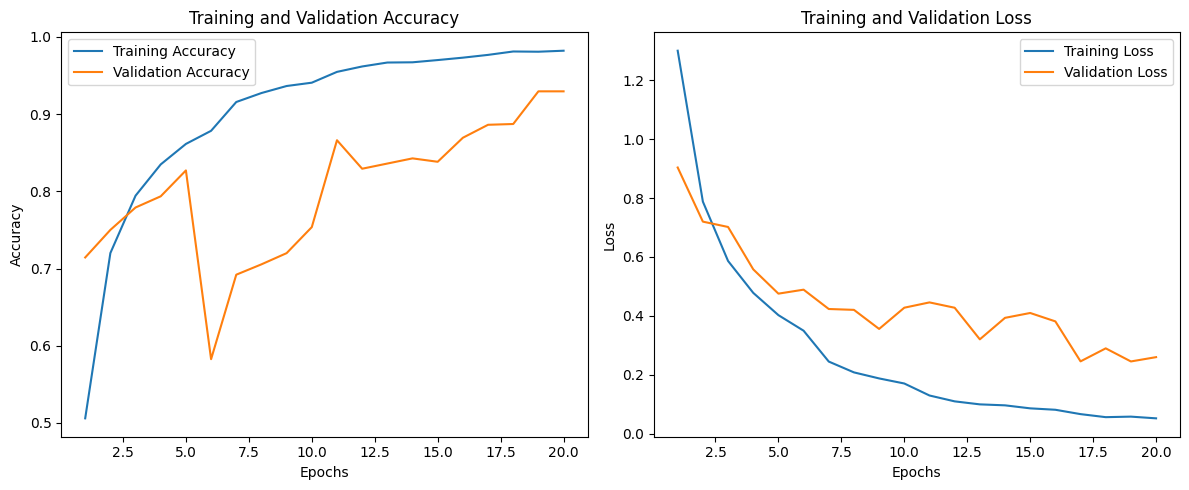

In [1]:
# Retrieving a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieving a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Getting number of epochs
epochs = range(len(acc))

# Plotting training and validation accuracy per epoch
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label="Training Accuracy")
plt.plot(epochs, val_acc, label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plotting training and validation loss per epoch
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()